In [119]:
# retrieve data from BigQuery


from google.cloud import bigquery
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import mlflow
import numpy as np

mlflow.set_experiment('SARIMAX_TUNING')

client = bigquery.Client()

query = """
DECLARE MaxDate DATETIME
  DEFAULT (
    SELECT MAX(run_date)
    FROM `executive-orders-448515.weekly_data_collected.weekly_variables_flattened`
  );

SELECT 
  * EXCEPT(run_date)
FROM `executive-orders-448515.weekly_data_collected.weekly_variables_flattened`
WHERE run_date = MaxDate
ORDER BY week_start ASC;
"""

raw_data = client.query_and_wait(query)
df = raw_data.to_dataframe()

In [120]:
# index rows by week
df['week_start'] = pd.to_datetime(df['week_start'])
df = df.sort_values(by='week_start', ascending=True)
df.set_index('week_start', inplace=True)

In [121]:
# replace outcome var outliers with median
median = df['orders_outcome_var'].median()
std = df['orders_outcome_var'].std()
df.loc[(df['orders_outcome_var'] - median).abs() > 3*std]=np.nan
df.fillna({'orders_outcome_var':median}, inplace = True)

# spline-interpolate exog vars to fill missing values
df_exog_interpolated = df.drop('orders_outcome_var', axis=1).astype(float).interpolate(method='spline', order = 3) # order 3 is cubic

In [122]:
# create principal components from exog vars
scaler = StandardScaler()
df_to_standardize = df_exog_interpolated.drop(['disapproving'], axis=1)
df_standardized = scaler.fit_transform(df_to_standardize)

pca = PCA( n_components=4) # data exploration determined that 4 PCs will be retained
principal_components = pca.fit_transform(df_standardized)
df_principal_components = pd.DataFrame(principal_components, columns=['PC1','PC2','PC3','PC4'], index=df_to_standardize.index)



In [123]:
df1 = df_principal_components.join(df['orders_outcome_var'])

In [140]:
from datetime import datetime
import itertools
import statsmodels.api as sm
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning, ConvergenceWarning
warnings.simplefilter('ignore', ValueWarning)
warnings.simplefilter('ignore', ConvergenceWarning)
# https://stackoverflow.com/questions/49547245/valuewarning-no-frequency-information-was-provided-so-inferred-frequency-ms-wi
# from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

import matplotlib.pyplot as plt


In [125]:
# Split train and test data 80/20
df_train = df1[:round(len(df1)*.8)]
df_test = df1[round(len(df1)*.8):]

In [126]:


# Hyperparameters tuning
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))] #52 here represents weeks

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[4]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))


Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 52)
SARIMAX: (0, 0, 1) x (0, 1, 0, 52)
SARIMAX: (0, 0, 1) x (0, 1, 1, 52)
SARIMAX: (0, 0, 1) x (1, 0, 0, 52)
SARIMAX: (0, 1, 0) x (0, 0, 1, 52)
SARIMAX: (0, 1, 0) x (0, 1, 0, 52)
SARIMAX: (0, 1, 0) x (0, 1, 1, 52)
SARIMAX: (0, 1, 0) x (1, 0, 0, 52)


In [130]:
df_results = pd.DataFrame(columns=['pdq', 'seasonal_pdq', 'AIC'])
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(endog=df_train['orders_outcome_var'],
                                            exog=df_train.drop(['orders_outcome_var'], axis=1),
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=True,
                                            enforce_invertibility=True)
            results = mod.fit(disp=False)
            df_results.loc[len(df_results)] = [param, param_seasonal, results.aic]
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except Exception as e:
            print(f'Error: {e}')
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 52)12 - AIC:4373.267901215109
ARIMA(0, 0, 0)x(0, 0, 1, 52)12 - AIC:4352.292075927954
ARIMA(0, 0, 0)x(0, 1, 0, 52)12 - AIC:4487.039150838176
ARIMA(0, 0, 0)x(0, 1, 1, 52)12 - AIC:4060.599244914284
ARIMA(0, 0, 0)x(1, 0, 0, 52)12 - AIC:4345.077524198968
ARIMA(0, 0, 0)x(1, 0, 1, 52)12 - AIC:4284.179200012013
ARIMA(0, 0, 0)x(1, 1, 0, 52)12 - AIC:4261.277174443869
ARIMA(0, 0, 0)x(1, 1, 1, 52)12 - AIC:4062.1158229342764
ARIMA(0, 0, 1)x(0, 0, 0, 52)12 - AIC:4345.0769371353435
ARIMA(0, 0, 1)x(0, 0, 1, 52)12 - AIC:4335.155742619386
ARIMA(0, 0, 1)x(0, 1, 0, 52)12 - AIC:4484.312636917446
ARIMA(0, 0, 1)x(0, 1, 1, 52)12 - AIC:4061.3871214000983
ARIMA(0, 0, 1)x(1, 0, 0, 52)12 - AIC:4332.140712781932
ARIMA(0, 0, 1)x(1, 0, 1, 52)12 - AIC:4285.347325299748


KeyboardInterrupt: 

In [131]:
# following model testing, choose order and seasonal order with lowest AIC
final_sarimax_model_params = df_results.iloc[df_results['AIC'].idxmin()]
print(final_sarimax_model_params['pdq'])
print(final_sarimax_model_params)

(0, 0, 0)
pdq                 (0, 0, 0)
seasonal_pdq    (0, 1, 1, 52)
AIC               4060.599245
Name: 3, dtype: object


In [132]:
final_model = sm.tsa.statespace.SARIMAX(endog=df_train['orders_outcome_var'],
                                        exog=df_train.drop(['orders_outcome_var'], axis=1),
                                        order=final_sarimax_model_params['pdq'],
                                        seasonal_order=final_sarimax_model_params['seasonal_pdq'],
                                        enforce_stationarity=True,
                                        enforce_invertibility=True)

final_results = final_model.fit(disp=False)
print(final_results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
PC1           -0.0283      0.083     -0.340      0.734      -0.191       0.135
PC2           -0.1234      0.052     -2.383      0.017      -0.225      -0.022
PC3            0.1766      0.098      1.809      0.070      -0.015       0.368
PC4           -0.1703      0.157     -1.085      0.278      -0.478       0.137
ma.S.L52      -0.9258      0.053    -17.457      0.000      -1.030      -0.822
sigma2         7.9815      0.540     14.773      0.000       6.923       9.040


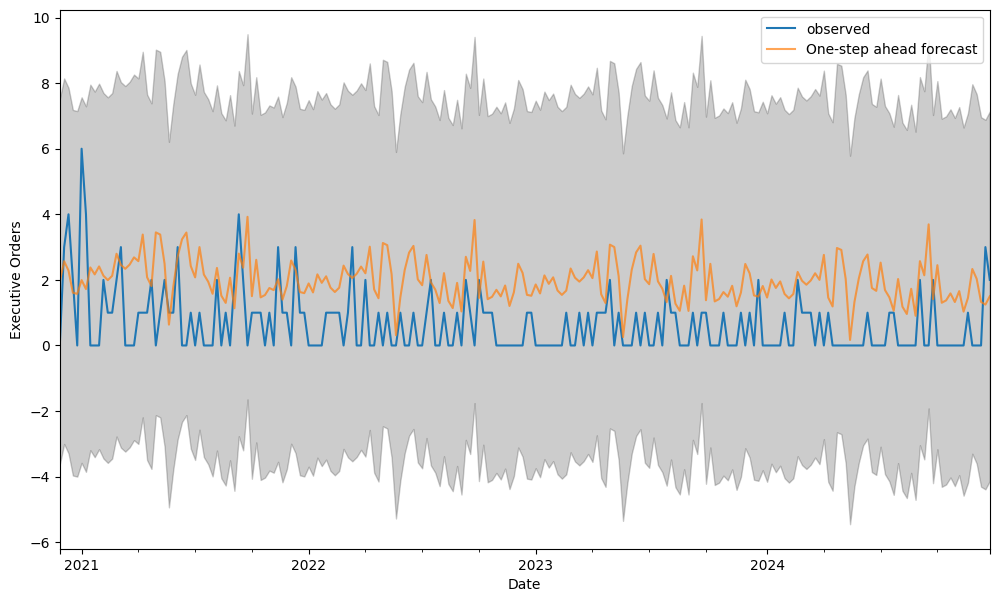

In [133]:
# Plot the forecasting results
pred = final_results.get_prediction(start=len(df_train['orders_outcome_var']),
                                    end=len(df_train['orders_outcome_var']) + len(df_test['orders_outcome_var']) -1,
                                    exog=df_test.drop(['orders_outcome_var'], axis = 1))
pred_ci = pred.conf_int() # Extract the confidence intervals for the predictions
ax = df_test['orders_outcome_var'].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead forecast', alpha=.7, figsize=(12, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Executive Orders')
plt.legend()
plt.show()

In [153]:
# write predicted values to a date-partitioned GCP BigQuery table
output_to_bq = pd.DataFrame(pred.predicted_mean)
output_to_bq.reset_index(inplace=True)
output_to_bq['bq_load_dt'] = datetime.today()
output_to_bq.rename(columns={'index':'week_start','predicted_mean':'predicted_orders'}, inplace=True)
print(output_to_bq)

table_id = 'weekly_data_predicted.executive_order_count'

job_config = bigquery.LoadJobConfig(
    schema=[bigquery.SchemaField("week_start", "DATE"),
            bigquery.SchemaField("predicted_orders", "FLOAT64"),
            bigquery.SchemaField("bq_load_dt", "DATE")],
    write_disposition="WRITE_APPEND")

job = client.load_table_from_dataframe(
    output_to_bq, table_id, job_config=job_config
)

# Wait for the load job to complete. (I omit this step)
job.result()

    week_start  predicted_orders                 bq_load_dt
0   2020-11-29          1.945482 2025-01-30 22:37:45.204517
1   2020-12-06          2.569600 2025-01-30 22:37:45.204517
2   2020-12-13          2.284163 2025-01-30 22:37:45.204517
3   2020-12-20          1.608991 2025-01-30 22:37:45.204517
4   2020-12-27          1.574835 2025-01-30 22:37:45.204517
..         ...               ...                        ...
209 2024-12-01          2.332587 2025-01-30 22:37:45.204517
210 2024-12-08          2.031740 2025-01-30 22:37:45.204517
211 2024-12-15          1.327612 2025-01-30 22:37:45.204517
212 2024-12-22          1.246941 2025-01-30 22:37:45.204517
213 2024-12-29          1.501177 2025-01-30 22:37:45.204517

[214 rows x 3 columns]


LoadJob<project=executive-orders-448515, location=US, id=ff6a547a-cc67-4a23-8f77-c6adfcd344b4>

In [ ]:
# write experiment results to mlflow

model_name = f"SARIMAX_run_at{datetime.now()}"
with mlflow.start_run(run_name="Sarimax") as run:
    mlflow.statsmodels.log_model(results,model_name,registered_model_name=model_name)
    mlflow.log_params({"order":(0,1,1),"seasonal_order":(0, 1, 1, 12),'enforce_stationarity':False,'enforce_invertibility':False})
    model_uri = f"runs:/{run.info.run_id}/{model_name}"
    print("Model saved in run %s" % run.info.run_id)
    print(f"Model URI: {model_uri}")
mlflow.end_run()